# TMDbから得られた映画情報のマルチクラス・ラベル分類

## データ準備

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data_path = 'df'

df = pd.read_csv(f'{data_path}/tmdb_movies.csv')
df

,id,title,genres,release_date,popularity,vote_average,vote_count,overview
0,364897,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2015-04-24,1.301,10.0,1,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...
1,190147,十字路,18,1928-05-11,0.989,7.2,9,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...
2,143,西部戦線異状なし,"18,10752",1930-10-24,11.206,7.8,457,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...
3,3063,我輩はカモである,"35,10752",1934-01-27,7.993,7.4,511,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...
4,630,オズの魔法使,"12,14,10751",1954-12-25,51.605,7.6,4176,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...
...,...,...,...,...,...,...,...,...
5240,744392,架空OL日記,35,2020-02-28,0.600,6.5,2,お笑い芸人のバカリズムが主演や脚本を務め、2017年に放送された連続ドラマの劇場版。原作は、...
5241,718498,あのこは貴族,18,2021-02-26,0.600,0.0,0,都会の異なる環境を生きる2人の女性が、恋愛や結婚だけではない人生を切り拓く姿を描くシスターフ...
5242,704933,仮面病棟,"80,53",2020-03-06,0.717,6.7,3,医師の速水(坂口健太郎)は、一日だけの当直医として元精神科病院に出向く。だがピエロの仮面をか...
5243,695376,水曜日が消えた,9648,2020-05-15,1.400,6.0,1,幼少期の交通事故が原因で、曜日ごとに7人の人格が入れ替わる青年は、思考や性格はバラバラだが、...


In [2]:
def count_genre_kind(x):
  return list(map(int, x.split(',')))


genres = list(set(sum(df['genres'].map(count_genre_kind).tolist(), [])))
genres.sort()
genres

[12,
 14,
 16,
 18,
 27,
 28,
 35,
 36,
 37,
 53,
 80,
 99,
 878,
 9648,
 10402,
 10749,
 10751,
 10752,
 10770]

In [3]:
def get_genre_list(x):
  x_l = list(map(int, x.split(',')))
  genre_label = [0 for i in range(len(genres))]
  for xl in x_l:
    for idx, genre in enumerate(genres):
      if xl == genre:
        genre_label[idx] = 1

  return genre_label

genre_labels = np.array(df['genres'].map(get_genre_list).tolist()).T.tolist()
for idx, genre in enumerate(genres):
  df[f'genre_{genre}'] = genre_labels[idx]

df.head()

,id,title,genres,release_date,popularity,vote_average,vote_count,overview,genre_12,genre_14,genre_16,genre_18,genre_27,genre_28,genre_35,genre_36,genre_37,genre_53,genre_80,genre_99,genre_878,genre_9648,genre_10402,genre_10749,genre_10751,genre_10752,genre_10770
0,364897,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2015-04-24,1.301,10.0,1,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,190147,十字路,18,1928-05-11,0.989,7.2,9,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,143,西部戦線異状なし,"18,10752",1930-10-24,11.206,7.8,457,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3063,我輩はカモである,"35,10752",1934-01-27,7.993,7.4,511,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,630,オズの魔法使,"12,14,10751",1954-12-25,51.605,7.6,4176,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## マルチクラス分類

### 前処理

In [4]:
# マルチクラス用のdfを違うオブジェクトで生成し、必要な列のみ抽出
mclass_df = df.copy()[['title', 'genres', 'overview']]
mclass_df.head()

,title,genres,overview
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...
1,十字路,18,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...
2,西部戦線異状なし,"18,10752",第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...
3,我輩はカモである,"35,10752",財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...
4,オズの魔法使,"12,14,10751",カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...


In [5]:
# genresの先頭を予測対象とする
def set_target(x):
  return int(x.split(',')[0])

# ジャンルの予測対象をセット
mclass_df['target'] = mclass_df['genres'].map(set_target)
# 必要な情報のみにそぎ落とし、全てのカラムを大文字化
mclass_df = mclass_df[['title', 'overview', 'target']].rename(columns=str.upper)
mclass_df.head()

,TITLE,OVERVIEW,TARGET
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...,28
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18
2,西部戦線異状なし,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12


In [6]:
import re

# テキストの前処理
def preprocessing(text):
  # 全角 => 半角
  text = text.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
  # 英語大文字を小文字化
  text = text.lower()
  # 削除する文字列
  remove_list = ['\n', '　', ' ']
  for rem_word in remove_list:
    text = text.replace(rem_word, '')
  # 数字列を0に置換
  text = re.sub('[0-9]+', '0', text)

  return text

In [7]:
mclass_df['OVERVIEW'] += mclass_df['TITLE']
mclass_df['OVERVIEW'] = mclass_df['OVERVIEW'].map(preprocessing)
mclass_df.head()

,TITLE,OVERVIEW,TARGET
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,0月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの0人は部屋でダラダラしていると豪華な...,28
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18
2,西部戦線異状なし,第0次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12


### Mecabインストール

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

!sed -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc &gt; /etc/mecabrc.new
!cp /etc/mecabrc /etc/mecabrc.org
!cp /etc/mecabrc.new /etc/mecabrc

### 分かち書き

In [9]:
import MeCab

def tokenize(text, target_pos=list(('名詞', '形容詞', '形容動詞', '動詞', '副詞'))):
  tokens = []
  mecab = MeCab.Tagger ('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
  mecab.parse('') #文字列がGCされるのを防ぐ
  node = mecab.parseToNode(text)
  while node:
    #単語を取得
    word = node.surface
    #品詞を取得
    pos = node.feature.split(',')[0]
    # 名詞の場合のみ抽出
    if pos in target_pos:
      tokens.append(word)
    #次の単語に進める
    node = node.next
  return tokens

In [74]:
# 分かち書きテスト
#tokenize('あの隣の気になる髪の短い子')

['隣', '気', 'なる', '髪', '短い', '子']

In [10]:
mclass_df['OVERVIEW_WAKATI'] = mclass_df['OVERVIEW'].map(lambda x: ' '.join(tokenize(x)))
mclass_df.head()

,TITLE,OVERVIEW,TARGET,OVERVIEW_WAKATI
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,0月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの0人は部屋でダラダラしていると豪華な...,28,0 月 月 閃 女 学 館 雪 泉 夜桜 雪 中 実践 修行 し 残り 0 人 部屋 ダラダ...
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18,江戸 裏町 ひっそり 暮らす 姉弟 弟 ある 女 めぐり 傷害事件 起こし しまう 姉 借金...
2,西部戦線異状なし,第0次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18,0 次 大戦 はじ てま ない ドイツ ある 町 群衆 歓声 送ら れ 戦場 向かう 部隊 ...
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35,財政難 フリードニア 共和国 富豪 夫人 援助 受ける ため 彼女 愛人 宰相 就任 さ せ...
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12,カンザス 農場 おじさん 夫婦 一緒 暮らす 少女 ドロシー ある日 竜巻 家 ごと 上空 ...


### 目的変数の作成

In [11]:
Y = np.array(mclass_df['TARGET'])
Y

array([  28,   18,   18, ...,   80, 9648,   16])

### 単語埋め込みのためのベクトライザー作成やロード

In [12]:
import string

def transform_w2v(text, vec):
  vec_size = vec['映画'].shape[0]
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vecs = [vec[word] for word in words if word in vec]  # 1語ずつベクトル化

  if len(vecs) != 0:
    # 各単語の平均ベクトルを出力
    return np.array(sum(vecs) / len(vecs))
  else:
    # 単語が全てvecになかったら、0ベクトルを出力
    return np.array(np.zeros(vec_size))

#### Word2Vec（独自学習）

In [13]:
wakati = mclass_df[['OVERVIEW_WAKATI']]
wakati.to_csv('wakati.csv', sep='\n', header=True, index=False)
wakati

,OVERVIEW_WAKATI
0,0 月 月 閃 女 学 館 雪 泉 夜桜 雪 中 実践 修行 し 残り 0 人 部屋 ダラダ...
1,江戸 裏町 ひっそり 暮らす 姉弟 弟 ある 女 めぐり 傷害事件 起こし しまう 姉 借金...
2,0 次 大戦 はじ てま ない ドイツ ある 町 群衆 歓声 送ら れ 戦場 向かう 部隊 ...
3,財政難 フリードニア 共和国 富豪 夫人 援助 受ける ため 彼女 愛人 宰相 就任 さ せ...
4,カンザス 農場 おじさん 夫婦 一緒 暮らす 少女 ドロシー ある日 竜巻 家 ごと 上空 ...
...,...
5240,お笑い芸人 バカリズム 主演 脚本 務め 0 年 放送 さ れ 連続ドラマ 劇場版 原作 バ...
5241,都会 異なる 環境 生きる 0 人 女性 恋愛 結婚 ない 人生 切り 拓く 姿 描く シス...
5242,医師 速水 坂口健太郎 一日 当直医 精神科病院 出向く ピエロ 仮面 かぶっ 凶悪犯 突然...
5243,幼少期 交通事故 原因 曜日 ごと 0 人 人格 入れ替わる 青年 思考 性格 バラバラ 曜...


In [ ]:
from gensim.models import word2vec
import logging

vec_size = 300
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentence_data = word2vec.LineSentence('wakati.csv')
vectorizer = word2vec.Word2Vec(sentence_data,
                         sg=1,            # Skip-gram
                         size=vec_size,   # 次元数
                         min_count=5,     # min_count回未満の単語を破棄
                         window=3,        # 文脈の最大単語数
                         hs=0,            # 階層ソフトマックス(ネガティブサンプリングするなら0)
                         negative=5,      # ネガティブサンプリング
                         iter=100         # Epoch数
                         )

In [15]:
vectorizer.most_similar('映画')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-07-12 13:44:35,709 : INFO : precomputing L2-norms of word weight vectors


[('初出演', 0.3618312180042267),
 ('興行', 0.3447723984718323),
 ('オムニバス', 0.335512638092041),
 ('劇中', 0.32575273513793945),
 ('ゲゲゲの鬼太郎', 0.3159177899360657),
 ('dx', 0.3144538402557373),
 ('サイレント', 0.31314191222190857),
 ('異なっ', 0.31186050176620483),
 ('シャンティ', 0.30939188599586487),
 ('製作会社', 0.30789369344711304)]

In [16]:
vectorizer['映画'].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


300

#### Word2Vec（ChiVe）

In [17]:
import gensim
import urllib.request
import sys

#ダウンロード
url = "https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc90_gensim.tar.gz"  #ファイルのURLを指定
urllib.request.urlretrieve(url,"chive.tar.gz")
#解凍
!tar -zxvf chive.tar.gz

vectorizer_chive = gensim.models.KeyedVectors.load("chive-1.2-mc90_gensim/chive-1.2-mc90.kv")

chive-1.2-mc90_gensim/
chive-1.2-mc90_gensim/chive-1.2-mc90.kv
chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy
chive-1.2-mc90_gensim/LICENSE
chive-1.2-mc90_gensim/README.md


2021-07-12 13:45:24,025 : INFO : loading Word2VecKeyedVectors object from chive-1.2-mc90_gensim/chive-1.2-mc90.kv
2021-07-12 13:45:26,113 : INFO : loading vectors from chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy with mmap=None
2021-07-12 13:45:26,349 : INFO : setting ignored attribute vectors_norm to None
2021-07-12 13:45:26,353 : INFO : loaded chive-1.2-mc90_gensim/chive-1.2-mc90.kv


In [18]:
vectorizer_chive.most_similar('映画')

2021-07-12 13:46:10,365 : INFO : precomputing L2-norms of word weight vectors


[('邦画', 0.7711033821105957),
 ('予告編', 0.7660966515541077),
 ('主演', 0.7257440090179443),
 ('ハリウッド', 0.7001019716262817),
 ('映画館', 0.6935902237892151),
 ('映画界', 0.689943253993988),
 ('劇映画', 0.6886698007583618),
 ('話題作', 0.684718132019043),
 ('映画化', 0.681873083114624),
 ('上映', 0.6801760196685791)]

In [19]:
vectorizer_chive['映画'].shape[0]

300

#### TF-IDF（独自学習）

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize,
                                   ngram_range=(1, 1),
                                   min_df=5)
vectors = vectorizer_tfidf.fit_transform(mclass_df['OVERVIEW'])
vectors.shape

(5245, 306313)

### 説明変数の作成

In [20]:
X = np.array([transform_w2v(text, vectorizer) for text in mclass_df['OVERVIEW_WAKATI']])
X_chive = np.array([transform_w2v(text, vectorizer_chive) for text in mclass_df['OVERVIEW_WAKATI']])

print('Word2Vec（独自学習）:', X.shape)
print('Word2Vec（ChiVe）:', X_chive.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Word2Vec（独自学習）: (5245, 300)
Word2Vec（ChiVe）: (5245, 300)


### 学習・検証・評価に分割

In [22]:
from sklearn.model_selection import train_test_split

# 独自学習のWord2Vec
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, Y, train_size=0.8, random_state=144)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, train_size=0.5, random_state=144)
# ChiVe
X_train_chive, X_valid_test_chive = train_test_split(X_chive, train_size=0.8, random_state=144)
X_valid_chive, X_test_chive = train_test_split(X_valid_test_chive, train_size=0.5, random_state=144)

print(f'{"="*20} 学習データ {"="*20}')
print('X:', X_train.shape)
print('X_chive:', X_train_chive.shape)
print('Y:', y_train.shape)
print(f'{"="*20} 検証データ {"="*20}')
print('X:', X_valid.shape)
print('X_chive:', X_valid_chive.shape)
print('Y:', y_valid.shape)
print(f'{"="*20} 評価データ {"="*20}')
print('X:', X_test.shape)
print('X_chive:', X_test_chive.shape)
print('Y:', y_test.shape)

==================== 学習データ ====================
X: (4196, 300)
X_chive: (4196, 300)
Y: (4196,)
==================== 検証データ ====================
X: (524, 300)
X_chive: (524, 300)
Y: (524,)
==================== 評価データ ====================
X: (525, 300)
X_chive: (525, 300)
Y: (525,)


### 学習・予測・精度評価

In [34]:
def print_true_pred(y_true, y_pred, text, limited_num=20):
  print(f'{"="*36} {text} {"="*36}')
  print('検証正解：', y_true[:limited_num])
  print('検証予測：', y_pred[:limited_num])

#### Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier as classifier

# モデル定義
clf = classifier(random_state=144)
clf_chive = classifier(random_state=144)
# 学習
clf.fit(X_train, y_train)
clf_chive.fit(X_train_chive, y_train)
# 予測
predict_vy = clf.predict(X_valid)
predict_y = clf.predict(X_test)
predict_vy_chive = clf_chive.predict(X_valid_chive)
predict_y_chive = clf_chive.predict(X_test_chive)
# 予測確率
predict_vy_prob = clf.predict_proba(X_valid)
predict_y_prob = clf.predict_proba(X_test)
predict_vy_prob_chive = clf_chive.predict_proba(X_valid_chive)
predict_y_prob_chive = clf_chive.predict_proba(X_test_chive)

# 中身
print_true_pred(y_valid, predict_vy, '検証（独自Word2Vec）')
print_true_pred(y_test, predict_y, '評価（独自Word2Vec）')
print_true_pred(y_valid, predict_vy_chive, '検証（ChiVe）')
print_true_pred(y_valid, predict_y_chive, '検証（ChiVe）')

==================================== 検証（独自Word2Vec） ====================================
検証正解： [   27    28    80    16    16    28    53    12    27    16 10752    18
    28    28    35    27    16    18    12    27]
検証予測： [18 28 18 18 18 18 28 28 28 18 18 18 28 16 18 28 18 18 28 18]
==================================== 評価（独自Word2Vec） ====================================
検証正解： [   35    16    28    16    35    35    35    16    18 10749    80    14
    18    12    80    16    16    35    18 10749]
検証予測： [18 16 28 28 28 28 18 16 18 18 28 16 18 18 18 18 16 18 18 18]
==================================== 検証（ChiVe） ====================================
検証正解： [   27    28    80    16    16    28    53    12    27    16 10752    18
    28    28    35    27    16    18    12    27]
検証予測： [18 28 16 18 16 18 28 16 18 18 18 18 28 28 35 28 35 18 18 18]
==================================== 検証（ChiVe） ====================================
検証正解： [   27    28    80    16    16    28    53    12    27   

In [36]:
# 単純な正解率
print('検証正解率：', np.sum(predict_vy == y_valid) / y_valid.size)
print('評価正解率：', np.sum(predict_y == y_test) / y_test.size)
print('検証正解率_chive：', np.sum(predict_vy_chive == y_valid) / y_valid.size)
print('評価正解率_chive：', np.sum(predict_y_chive == y_test) / y_test.size)

検証正解率： 0.3969465648854962
評価正解率： 0.43238095238095237
検証正解率_chive： 0.4217557251908397
評価正解率_chive： 0.44952380952380955


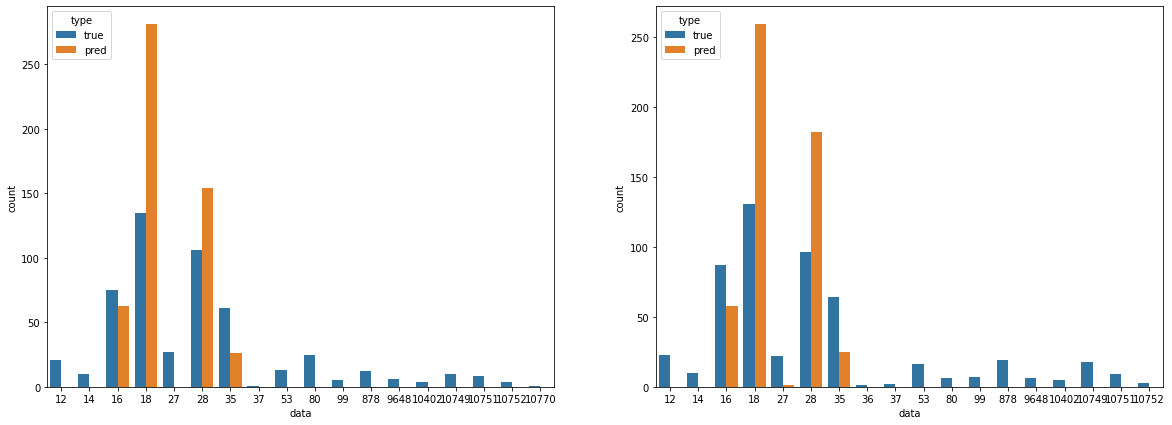

In [40]:
# DF化
## valid
pred_df = pd.DataFrame({'data': predict_vy, 'type': 'pred'})
true_df = pd.DataFrame({'data': y_valid, 'type': 'true'})
valid_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
## test
pred_df = pd.DataFrame({'data': predict_y, 'type': 'pred'})
true_df = pd.DataFrame({'data': y_test, 'type': 'true'})
test_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
# 予測データのヒストグラム
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.countplot(data=valid_df, x='data', hue='type', ax=ax1)
sns.countplot(data=test_df, x='data', hue='type', ax=ax2)

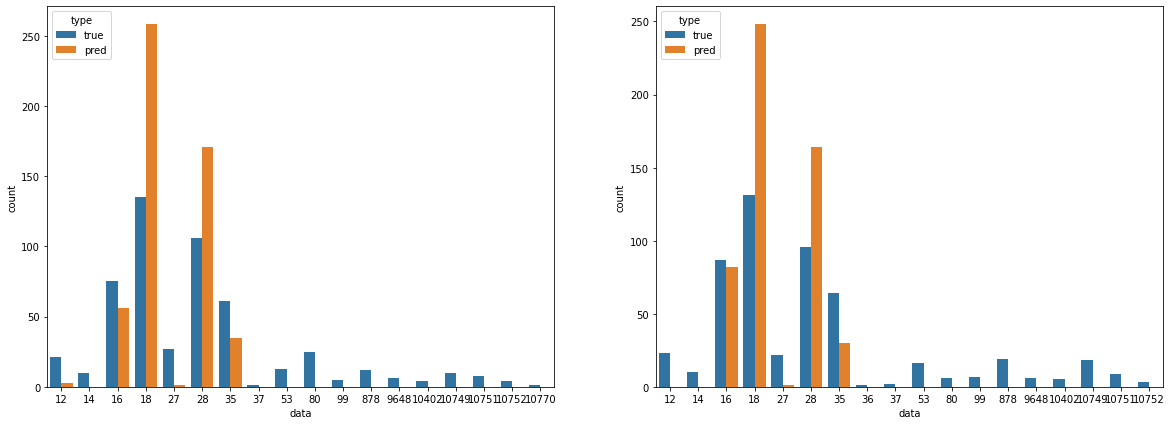

In [41]:
# DF化（ChiVe）
## valid
pred_df = pd.DataFrame({'data': predict_vy_chive, 'type': 'pred'})
true_df = pd.DataFrame({'data': y_valid, 'type': 'true'})
valid_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
## test
pred_df = pd.DataFrame({'data': predict_y_chive, 'type': 'pred'})
true_df = pd.DataFrame({'data': y_test, 'type': 'true'})
test_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
# 予測データのヒストグラム
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.countplot(data=valid_df, x='data', hue='type', ax=ax1)
sns.countplot(data=test_df, x='data', hue='type', ax=ax2)

In [27]:
from sklearn.metrics import classification_report

# 様々な精度結果
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

          12       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        10
          16       0.41      0.28      0.33        87
          18       0.44      0.86      0.58       131
          27       0.00      0.00      0.00        22
          28       0.42      0.80      0.55        96
          35       0.52      0.20      0.29        64
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          53       0.00      0.00      0.00        16
          80       0.00      0.00      0.00         6
          99       0.00      0.00      0.00         7
         878       0.00      0.00      0.00        19
        9648       0.00      0.00      0.00         6
       10402       0.00      0.00      0.00         5
       10749       0.00      0.00      0.00        18
       10751       0.00      0.00      0.00         9
       10752       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(classification_report(y_test, predict_y_chive))

              precision    recall  f1-score   support

          12       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        10
          16       0.45      0.43      0.44        87
          18       0.46      0.86      0.60       131
          27       1.00      0.05      0.09        22
          28       0.45      0.77      0.57        96
          35       0.37      0.17      0.23        64
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          53       0.00      0.00      0.00        16
          80       0.00      0.00      0.00         6
          99       0.00      0.00      0.00         7
         878       0.00      0.00      0.00        19
        9648       0.00      0.00      0.00         6
       10402       0.00      0.00      0.00         5
       10749       0.00      0.00      0.00        18
       10751       0.00      0.00      0.00         9
       10752       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Naive Bayes

検証True: 195
検証False: 329
検証正解率: 0.37213740458015265
テストTrue: 214
テストFalse: 311
テスト正解率: 0.4076190476190476
              precision    recall  f1-score   support

          12       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        10
          16       0.69      0.13      0.21        87
          18       0.37      0.95      0.53       131
          27       0.00      0.00      0.00        22
          28       0.46      0.79      0.58        96
          35       1.00      0.03      0.06        64
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          53       0.00      0.00      0.00        16
          80       0.00      0.00      0.00         6
          99       0.00      0.00      0.00         7
         878       0.00      0.00      0.00        19
        9648       0.00      0.00      0.00         6
       10402       0.00      0.00      0.00         5
       10749       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


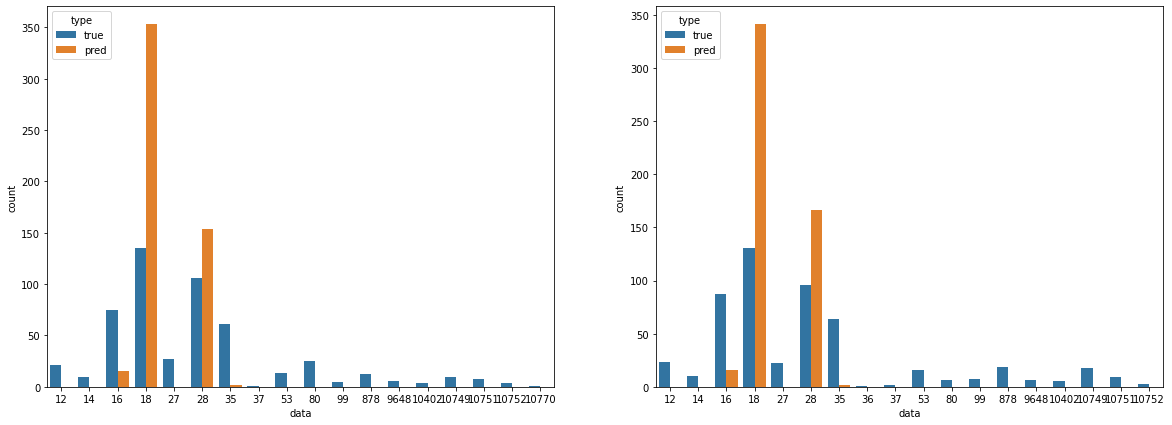

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

clf = MultinomialNB(alpha=.01)
mm = preprocessing.MinMaxScaler()
try:
  X_train_mm = mm.fit_transform(X_train)
except:
  X_train_mm = X_train
try:
  X_valid_mm = mm.transform(X_valid)
except:
  X_valid_mm = X_valid
try:
  X_test_mm = mm.transform(X_test)
except:
  X_test_mm = X_test
learn_pred_accuracy(clf, X_train_mm, y_train, X_valid_mm, y_valid, X_test_mm, y_test)

In [47]:
def learn_pred_accuracy(clf, train_x, train_y, valid_x, valid_y, test_x, test_y):
  # 学習
  clf.fit(train_x, train_y)
  # 予測
  predict_vy = clf.predict(valid_x)
  predict_y = clf.predict(test_x)
  # 正解率
  print('検証True:', np.count_nonzero(predict_vy == valid_y))
  print('検証False:', np.count_nonzero(predict_vy != valid_y))
  print('検証正解率:', np.count_nonzero(predict_vy == valid_y) / len(valid_y))
  print('テストTrue:', np.count_nonzero(predict_y == test_y))
  print('テストFalse:', np.count_nonzero(predict_y != test_y))
  print('テスト正解率:', np.count_nonzero(predict_y == test_y) / len(test_y))
  # 様々な精度結果
  print(classification_report(test_y, predict_y))
  # 正解と予測データ
  print('検証正解：', valid_y[:20])
  print('検証予測：', predict_vy[:20])
  print('test正解：', test_y[:20])
  print('test予測：', predict_y[:20])
  # DF化
  ## valid
  pred_df = pd.DataFrame({'data': predict_vy, 'type': 'pred'})
  true_df = pd.DataFrame({'data': valid_y, 'type': 'true'})
  valid_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  ## test
  pred_df = pd.DataFrame({'data': predict_y, 'type': 'pred'})
  true_df = pd.DataFrame({'data': test_y, 'type': 'true'})
  test_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  # 予測データのヒストグラム
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
  sns.countplot(data=valid_df, x='data', hue='type', ax=ax1)
  sns.countplot(data=test_df, x='data', hue='type', ax=ax2)

#### XGB

In [63]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def predict_by_xgb():
  # DMatrixに変換
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_valid, label=y_valid)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # ハイパーパラメータの設定
  params = {'objective': 'multi:softmax',
            'silent': 1,
            'random_state': 144,
            'eval_metric': 'auc',
            'num_class': len(genres)}
  # 学習回数
  num_round = 500
  # アーリーストッピング
  es_round = 50

  # 訓練データはdtrain、評価用のテストデータはdvalidで設定
  watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
  # 学習
  xgb_model = xgb.train(params,
                    dtrain,
                    num_round,
                    evals=watchlist,
                    early_stopping_rounds=es_round
                    )
  # 予測
  y_pred_vali = xgb_model.predict(dvalid, ntree_limit = xgb_model.best_ntree_limit)
  y_pred_test = xgb_model.predict(dtest, ntree_limit = xgb_model.best_ntree_limit)

  # 正解データ
  valid_true = np.array(y_valid)
  test_true = np.array(y_test)
  # 結果出力
  print(f'{"="*36} XGB Classifier {"="*36}')
  print('検証用')
  print('予測：', y_pred_vali)
  print('正解：', valid_true)
  print('評価用')
  print('予測：', y_pred_test)
  print('正解：', test_true)
  print(f'valid_RMSE: {np.sqrt(mean_squared_error(valid_true, y_pred_vali)):.4f}')
  print(f'test_RMSE: {np.sqrt(mean_squared_error(test_true, y_pred_test)):.4f}')
  
  # 正規化を戻して、実際のアクティビティカウント値を出力
  ## 予測データを戻す
  """
  y_pred_vali = norm2real(y_pred_vali)
  y_pred_test = norm2real(y_pred_test)
  ## 正解データを戻す
  valid_true = np.array(y_valid_real)
  test_true = np.array(y_test_real)
  print(f'{"="*18} real data RMSE {"="*18}')
  print('検証用')
  print('予測：', y_pred_vali)
  print('正解：', valid_true)
  print('評価用')
  print('予測：', y_pred_test)
  print('正解：', test_true)
  print(f'valid_RMSE: {np.sqrt(mean_squared_error(valid_true, y_pred_vali)):.4f}')
  print(f'test_RMSE: {np.sqrt(mean_squared_error(test_true, y_pred_test)):.4f}')
  """

predict_by_xgb()

XGBoostError: ignored

検証True: 230
検証False: 294
検証正解率: 0.4389312977099237
テストTrue: 232
テストFalse: 293
テスト正解率: 0.4419047619047619
              precision    recall  f1-score   support

          12       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        10
          16       0.50      0.46      0.48        87
          18       0.45      0.70      0.55       131
          27       0.45      0.23      0.30        22
          28       0.46      0.72      0.56        96
          35       0.35      0.36      0.36        64
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          53       0.00      0.00      0.00        16
          80       0.00      0.00      0.00         6
          99       0.50      0.14      0.22         7
         878       0.20      0.05      0.08        19
        9648       0.00      0.00      0.00         6
       10402       0.00      0.00      0.00         5
       10749       0.50      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


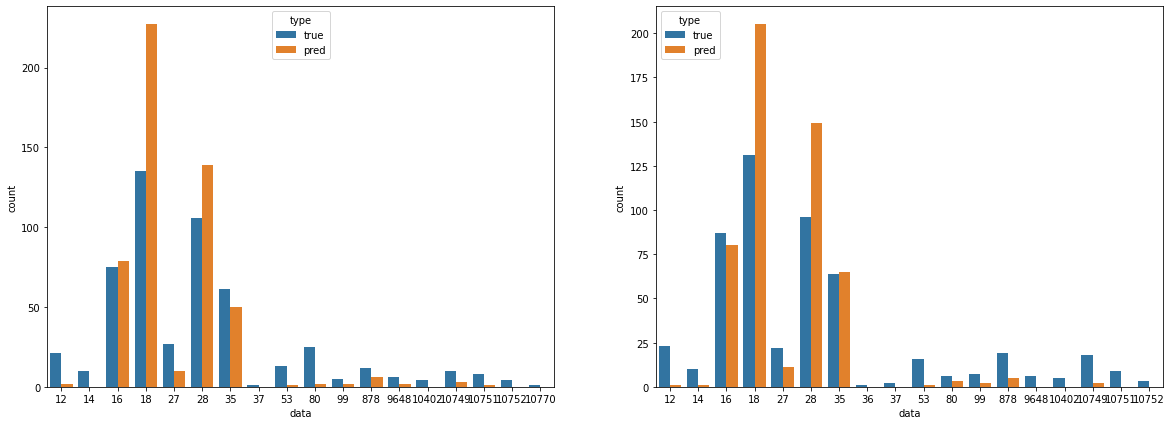

In [64]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=144, objective='binary:logistic')
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

#### LSTM（Keras）

In [70]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# データを整形
def format_training_data(nb_of_samples, sequence_len):
    # 学習データを整形
    X = np.array(X_train)
    # 正解データを整形
    t = np.array(y_train)
    # LSTMに与える入力のため、(サンプル, 時刻, 特徴量の次元) の3次元にする
    return X.reshape((nb_of_samples, sequence_len, 1)), t

def run_lstm(nhu=256, bs=2, lr=0.0001):
  input_dim = 1                             # 入力データの次元数
  output_dim = 1                            # 出力データの次元数
  num_hidden_units = nhu                    # 隠れ層のユニット数
  len_sequence = X_train.shape[1]           # 時系列の長さ
  batch_size = bs                           # ミニバッチサイズ
  num_of_training_epochs = 100              # 学習エポック数
  learning_rate = lr                        # 学習率
  num_training_samples = X_train.shape[0]   # 学習データのサンプル数

  X, t = format_training_data(num_training_samples, len_sequence)

  # モデル構築
  model = Sequential()
  model.add(LSTM(
      num_hidden_units,
      input_shape=(len_sequence, input_dim),
      return_sequences=False))
  model.add(Dense(output_dim))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate))
  model.summary()

  # アーリーストッピング
  #early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=50)

  # データの整形
  ## (サンプル, 時刻, 特徴量の次元) の3次元の入力を与える
  X_valid_np = np.array(X_valid)
  X_test_np = np.array(X_test)
  X_valid_np = X_valid_np.reshape((X_valid_np.shape[0], X_valid_np.shape[1], 1))
  X_test_np = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))
  ## 正解データ
  valid_true = np.array(y_valid)
  test_true = np.array(y_test)

  # 学習
  model.fit(
      X, t,
      batch_size=batch_size,
      epochs=num_of_training_epochs,
      validation_data=(X_valid_np, valid_true)
      #validation_split=0.1,
      #callbacks=[early_stopping]
  )

  # 予測
  ## 検証用
  y_pred_vali = np.ravel(model.predict(X_valid_np))
  ## 評価用
  y_pred_test = np.ravel(model.predict(X_test_np))

  # 結果出力
  print(f'{"="*36} LSTM {"="*36}')
  print('検証用')
  print('予測：', y_pred_vali)
  print('正解：', valid_true)
  print('評価用')
  print('予測：', y_pred_test)
  print('正解：', test_true)
  print(f'valid_RMSE: {np.sqrt(mean_squared_error(valid_true, y_pred_vali)):.4f}')
  print(f'test_RMSE: {np.sqrt(mean_squared_error(test_true, y_pred_test)):.4f}')

  # 正規化を戻して、実際のアクティビティカウント値を出力
  ## 予測データを戻す
  y_pred_vali = norm2real(y_pred_vali)
  y_pred_test = norm2real(y_pred_test)
  ## 正解データを戻す
  valid_true = np.array(y_valid_real)
  test_true = np.array(y_test_real)
  print(f'{"="*18} real data RMSE {"="*18}')
  print('検証用')
  print('予測：', y_pred_vali)
  print('正解：', valid_true)
  print('評価用')
  print('予測：', y_pred_test)
  print('正解：', test_true)
  valid_rmse = np.sqrt(mean_squared_error(valid_true, y_pred_vali))
  test_rmse = np.sqrt(mean_squared_error(test_true, y_pred_test))
  print(f'valid_RMSE: {valid_rmse:.4f}')
  print(f'test_RMSE: {test_rmse:.4f}')

run_lstm(nhu=256, bs=1024, lr=0.0001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 81s 14s/step - loss: nan - val_loss: nan
Epoch 2/100
5/5 [==============================] - 69s 13s/step - loss: nan - val_loss: nan
Epoch 3/100
5/5 [==============================] - 67s 13s/step - loss: nan - val_loss: nan
Epoch 4/100
5/5 [==============================] - 67s 13s/step - loss: nan - val_loss: nan
Epoch 5/100
5/5 [==============================] - 68s 13s/step - loss: nan - val_loss: nan
Epoch 6/100
5/5 [==============================] -

KeyboardInterrupt: ignored

In [68]:
X_train.shape

(4196, 300)